In [1]:
import numpy as np
from scipy.stats import special_ortho_group
import jax.numpy as jnp
from jax import grad, vmap
from Mondrian_forest import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import pickle

dim_in = 5
active = 2
def simulate_y(x, rotation, seed = 0, noise_sig2 = 0.01):
    res = jnp.dot(x, rotation)
    res = (res ** 2) * -0.25
    res = jnp.exp(res)
    print(res)
    print(res.shape)
    projected = jnp.concatenate([jnp.ones(active), jnp.zeros(dim_in - active)])
    y = 5 * jnp.max(res * projected, axis = 1)
    r_noise = np.random.RandomState(seed)
    
    noise = r_noise.randn(1)[0] * jnp.sqrt(noise_sig2)
    y = y + noise
    return y


n = 2000
n_test = 1000
tries = 10


x_train, _, x_test, _, _ = pickle.load(open('axis_aligned_data.pickle', 'rb'))

x_train = x_train[:, :dim_in]
x_test = x_test[:, :dim_in]

rotation = np.identity(dim_in)
rotation[1,0] = 1
rotation[2,0] = 1
rotation[3,1] = rotation[4,1] = 1

y_train = simulate_y(x_train, rotation)

y_test = simulate_y(x_test, rotation)

sample_range = [100, 200, 400, 800, 1600]

M = 10                      # number of Mondrian trees to use
delta = 0                   # ridge regression delta


[[0.61892295 0.9655229  0.8596457  0.8984586  0.86450815]
 [0.95056915 0.82320267 0.99970126 0.9553526  0.91884756]
 [0.4927992  0.9983629  0.92797434 0.994096   0.858548  ]
 ...
 [0.79139704 0.9623017  0.9863752  0.90097594 0.9192191 ]
 [0.99279016 0.99987704 0.8492992  0.8497363  0.8287519 ]
 [0.8646378  0.35749704 0.9194676  0.8609537  0.89495164]]
(2000, 5)
[[0.96387684 0.9580142  0.990949   0.98046345 0.96675694]
 [0.8393922  0.30991673 0.8385023  0.77982557 0.9895526 ]
 [0.9999734  0.96800137 0.99996305 0.85677004 0.97655725]
 ...
 [0.99770665 0.9784211  0.8468636  0.80619603 0.9878022 ]
 [0.37657666 0.9577915  0.88234407 0.9999308  0.9476341 ]
 [0.73734605 0.95556104 0.91620356 0.81786454 0.9667264 ]]
(1000, 5)


In [2]:
rotation

array([[1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 1.]])

In [3]:
x_train, _, x_test, _, _ = pickle.load(open('axis_aligned_data.pickle', 'rb'))

x_train = x_train[:, :dim_in]
x_test = x_test[:, :dim_in]

In [4]:
from Simulations.functions import *

fn = SimulatedData(dim_in, active, rotation="simple", fun="max")

In [5]:
true_H = fn.get_true_H(x_test)
true_H/two_one_norm(true_H)

Array([[0.5233795 , 0.5233795 , 0.5233795 , 0.        , 0.        ],
       [0.5233795 , 1.0249103 , 0.5233795 , 0.50153077, 0.5015308 ],
       [0.5233795 , 0.5233795 , 0.5233795 , 0.        , 0.        ],
       [0.        , 0.50153077, 0.        , 0.50153077, 0.5015308 ],
       [0.        , 0.5015308 , 0.        , 0.5015308 , 0.5015308 ]],      dtype=float32)

# Save training history

In [6]:
lifetime = 5
from Mondrian_RF.Mondrian_forest import MondrianForestTransformer

# Mondrian Forest
forests = {}
for i in range(len(sample_range)):
    n_sim = sample_range[i]
    forests[n_sim] = []
    for trial in tqdm(range(tries)):
        forest = MondrianForestTransformer(n_estimators=M, lifetime=lifetime, step_size=0.5, random_state=n_sim * (trial + 1))
        forest.fit(x_train[:n_sim], y_train[:n_sim])
        forests[n_sim].append(forest)

100%|██████████| 10/10 [01:47<00:00, 10.77s/it]


# Get H estimate

In [7]:
H_est = []
for i in range(len(sample_range)):
    n_sim = sample_range[i]
    dist = {'n': n_sim, 'H': []}
    for trial in range(tries):
        H_0 = forests[n_sim][trial].H
        dist['H'].append(H_0)
    H_est.append(dist)

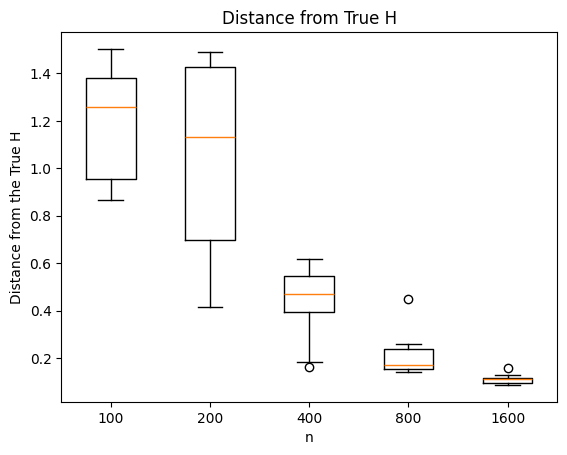

In [8]:
from util import *
np.set_printoptions(precision=4)
plot_H_estimates(H_est, true_H, get_angle_distance, sample_range, active)

In [9]:
lifetime_max = 5
n_sim = 1600
results = []
results.append(
    evaluate_all_lifetimes(x_train[:n_sim,], 
                           y_train[:n_sim], 
                           x_test, y_test, M, lifetime_max, delta))

In [10]:
x_train_transformed, x_test_transformed = transform_data(true_H/two_one_norm(true_H), x_train, x_test)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, M, lifetime_max, delta))

In [11]:
H_1 = H_est[4]['H'][0]/two_one_norm(H_est[4]['H'][0])

x_train_transformed, x_test_transformed = transform_data(H_1, x_train, x_test)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, M, lifetime_max, delta))

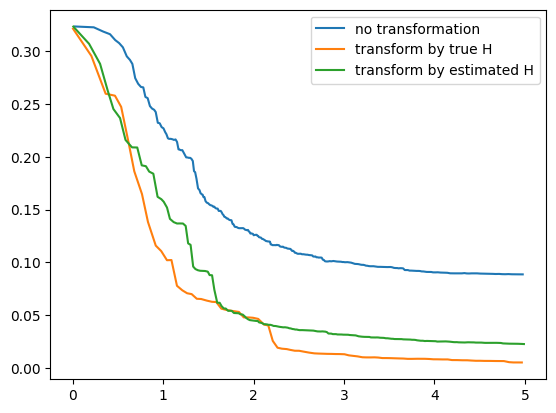

In [12]:
plt.plot(results[0][0]['times'], results[0][0]['mse'], label = 'no transformation')
plt.plot(results[1][0]['times'], results[1][0]['mse'], label = 'transform by true H')
plt.plot(results[2][0]['times'], results[2][0]['mse'], label = 'transform by estimated H')
plt.legend()

In [13]:
for i in range(len(sample_range)):
    n_sim = sample_range[i]
    for trial in tqdm(range(tries)):
        forests[n_sim][trial].reiterate()

100%|██████████| 10/10 [01:00<00:00,  6.09s/it]


In [14]:
H_est = []
for i in range(len(sample_range)):
    n_sim = sample_range[i]
    for trial in range(tries):
        H_0 = forests[n_sim][trial].H
        dist['H'].append(H_0)
    H_est.append(dist)

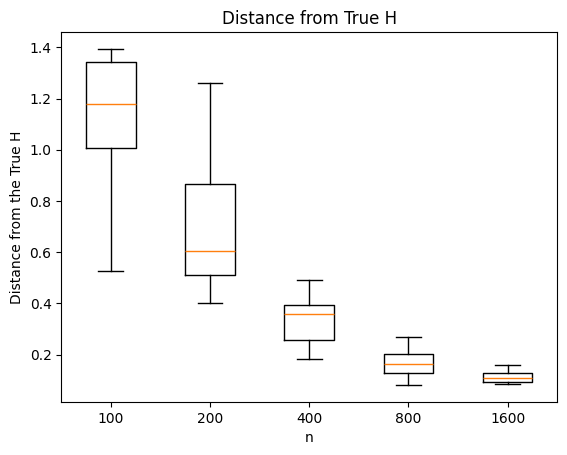

In [20]:
def plot_dist(forests, title, true_H, norm_func, sample_range, active, tries = 10):
    plot_data = []
    for i in range(len(sample_range)):
        n_sim = sample_range[i]
        alter_dist = {'n': n_sim, 'dist':[]}
        for trial in range(tries):
            H_0 = forests[n_sim][trial].H
            alter_dist['dist'].append(norm_func(H_0, true_H, active))
        plot_data.append(alter_dist)
    plot_trend(plot_data, 'n', 'dist', title, ylabel='Distance from the True H')


def plot_H_estimates(forests, true_H, norm_func, sample_range, active):
    plot_dist(forests, 'Distance from True H', true_H, norm_func, sample_range, active)

plot_H_estimates(forests, true_H, get_angle_distance, sample_range, active)

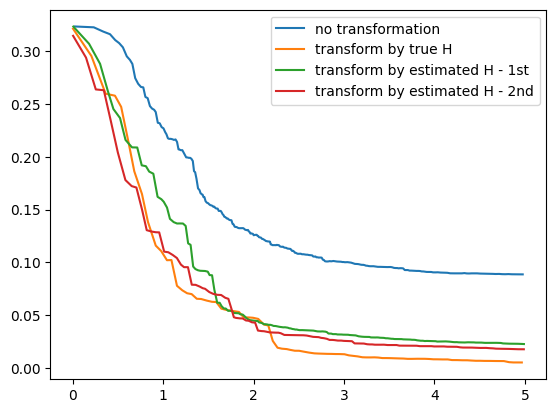

In [16]:
H_2 = H_est[4]['H'][0]/two_one_norm(H_est[4]['H'][0])

x_train_transformed, x_test_transformed = transform_data(H_2, x_train_transformed, x_test_transformed)
results.append(
    evaluate_all_lifetimes(x_train_transformed[:n_sim, ], 
                           y_train[:n_sim], 
                           x_test_transformed, y_test, M, lifetime_max, delta))

plt.plot(results[0][0]['times'], results[0][0]['mse'], label = 'no transformation')
plt.plot(results[1][0]['times'], results[1][0]['mse'], label = 'transform by true H')
plt.plot(results[2][0]['times'], results[2][0]['mse'], label = 'transform by estimated H - 1st')
plt.plot(results[3][0]['times'], results[3][0]['mse'], label = 'transform by estimated H - 2nd')
plt.legend()